In [3]:
from os import listdir
from datetime import datetime
from math import ceil, log, exp
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import re
import sympy as sym
#allow us to move inside a plotted graphic while it's open.
#%matplotlib widget 

In [ ]:
pathDataCSV='Donnees_Deezer/hits2020/'
my_files = listdir(pathDataCSV)
metadata=pd.read_csv("Donnees_Deezer/metadata.csv")
nb_date_to_show = 15

for filename in my_files:
    print(filename + ' - ' + metadata[metadata['song_id'] == filename.removesuffix('.csv')]["song_title"].tolist()[0] + ' - ' 
          + (metadata[metadata['song_id'] == filename.removesuffix('.csv')])["artist_name"].tolist()[0])

In [7]:
#Utilities functions
def weekly_average(df):
    df2 = {"d":[], "nb_users":[]}
    sum=0
    c=0
    val=0
    #enumerate every df values to make a weekly average by summing every listening of the week
    for i, v in enumerate(df["d"]):
        sum+=df['nb_users'][i]
        c+=1
        if i%7==6:
            df2["nb_users"].append(sum/c)
            df2["d"].append(v) #add the date to the dataframes
            sum=0
            c=0
        val=v
    df2["nb_users"].append(sum/c) #add the last points that were not plotted when the total number is not a multiple of 7
    df2["d"].append(v)
    return pd.DataFrame(df2)

def plot_graphic(df, xname, yname, filename):
    """
    plot the graphic from pd.Dataframe df,
    add title and readable date from df
    """
    g=sns.lineplot(data=df, x=xname, y=yname)
    plt.title((metadata[metadata['song_id'] == filename.removesuffix('.csv')])["song_title"].tolist()[0] + ' - ' 
              + (metadata[metadata['song_id'] == filename.removesuffix('.csv')])["artist_name"].tolist()[0])
    
    #Hide most of the dates to keep them readable
    n=ceil(len(df['d'])/(nb_date_to_show-1))
    labels=[]
    for i, label in enumerate(g.xaxis.get_ticklabels()):
        if i % n != 0:
            label.set_visible(False)
            labels.append(label)
    plt.xticks(rotation=45)

In [8]:
def get_id_from_title(title):
    return metadata[metadata['song_title'] == title]["song_id"].tolist()[0]

def get_title_from_id(id):
    return metadata[metadata['song_id'] == int(id)]["song_title"].tolist()[0]

def moindre_carres(Y1, Y2):
    assert len(Y1)==len(Y2)
    maxY1=max(Y1)
    maxY2=max(Y2)
    error = 0
    for i in range(len(Y1)):
        error+=((Y1[i]/maxY1)-(Y2[i]/maxY2))**2
    return error/len(Y1)

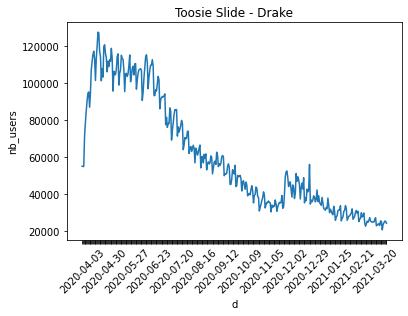

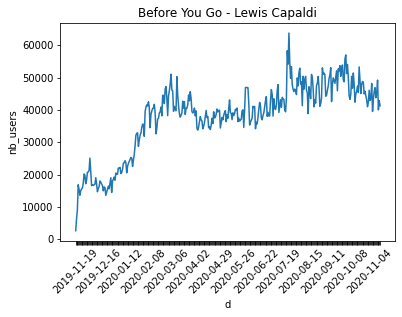

In [11]:
#Show every graphs
for f in my_files:
    #if f != str(get_id_from_title("Santé"))+".csv" :continue
    plt.close()
    df=pd.read_csv(pathDataCSV + f).sort_values(by="d")
    plot_graphic(df, "d", "nb_users", f)
    plt.show()

In [14]:
#Modèle à compartiment - Fonctions

x = sym.Symbol('x')

z   = 0.94 #pourcentage initial sain
p11 = 0.45 #rester sain
p14 = 0.5 # ne jamais l'écouter
p12 = 1-p11-p14 #etre exposé
p22 = 0.96 #rester exposé
p23 = 0.01 #arreter l'écoute
p24 = 0.01 #ne plus jamais ecouter la chanson
p25 = 1-p22-p23-p24 #devenir fan
p32 = 0.1 #se remettre à écouter G->I
p33 = 0.8 #rester neutre G
p34 = 1-p32-p33 #devenir rebuté depuis guérit ??
p53 = 0.01 #être gueris F->G
p55 = 1-p53 #rester fan

def calcul_courbe(l, z, p11, p12, p14, p22, p23, p24, p25, p32, p33, p34, p53, p55):
    for p in [z, p11, p14, p12, p22, p23, p24, p25, p32, p33, p34, p53, p55]:
        assert(0<=p<=1)
    assert(p11+p12+p14 == 1)
    assert(p22+p23+p24+p25 == 1)
    assert(p53+p55 == 1)
    
    #create legend to save parameters
    names=["z", "p11", "p14", "p12", "p22", "p23", "p24", "p25", "p32", "p33", "p34", "p53", "p55"]
    val=[z, p11, p14, p12, p22, p23, p24, p25, p32, p33, p34, p53, p55]
    probs = "   " + "\n   ".join([f'{names[i]}={round(val[i],3)}' for i in range(len(names))])

    #solve system
    S = sym.Symbol('S')
    C = sym.Symbol('C')
    G = sym.Symbol('G')
    II = sym.Symbol('II')
    F = sym.Symbol('F')

    sol = sym.solve([
                sym.Eq(z+p11*x*S,S),
                sym.Eq((1-z)+x*p12*S+x*p22*C+x*p32*G,C),
                sym.Eq(p33*x*G+x*p23*C+x*p53*F,G),
                sym.Eq(x*II+x*p14*S+x*p34*G+x*p24*C,II),
                sym.Eq(x*p55*F+x*p25*C,F)]
                ,
                (S,C,G,II,F))

    #décomposition en element simple 
    s=""
    #print(sol[C])
    partfracC=sym.apart(sol[C],full=True).doit()
    #print("C : " + str(partfracC))
    s+=str(partfracC).replace(" ","")
    partfracF=sym.apart(sol[F],full=True).doit()
    #print("F : " + str(partfracF))
    s+=str(partfracF).replace(" ","")

    #extrait les constantes
    str_rfloat = "[-+]?(?:\d*\.\d+|\d+)"
    rfloat = re.compile(str_rfloat)
    frac_deg1 = re.compile(f"{str_rfloat}/\(x{str_rfloat}\)")#element simple de type a/(x+b)
    frac_deg1bis = re.compile(f"{str_rfloat}/\({str_rfloat}\*x-1\.0\)")#element simple de type a/(cx-1)
    deg1 = frac_deg1.findall(s)
    deg1bis = frac_deg1bis.findall(s)

    AB = []
    for i in range(len(deg1)):
        tmp = rfloat.findall(deg1[i])
        b = - float(tmp[1])
        a = - float(tmp[0])/b
        AB.append([a,b])
    for i in range(len(deg1bis)):
        tmp = rfloat.findall(deg1bis[i])
        b = 1/float(tmp[1])
        a = - float(tmp[0])
        AB.append([a,b])

    #construit la fonction
    Y=[]
    Exp=[1]*len(AB)

    for i in range(l):
        sum=0
        for k in range(len(AB)):
            Exp[k]*=AB[k][1]
            sum+=AB[k][0]/Exp[k]
        Y.append(sum)
    return (Y, probs)

def scale(df,Y):
    """plot les valeurs de Y corrigées pour que max(f["nb_users"])=max(Y)
    ATTENTION len(df["2"]) doit être == len(Y)
    """
    cor=max(df["nb_users"])/max(Y)
    print(cor)
    Y2=list(map(lambda x:x*cor, Y))
    plt.plot(df["d"],Y2)

def calcul_courbe_aux(L, z, p11, p14, p22, p24, p25, p32, p55):
        Y, probs = calcul_courbe(len(L), z, p11, p14, 1-p11-p14, p22, 1-p22-p24-p25, p24, p25, p32, 1-p32, 0, 1-p55, p55)
        cor=max(L)/max(Y)
        Y2=list(map(lambda x:x*cor, Y))
        return Y2

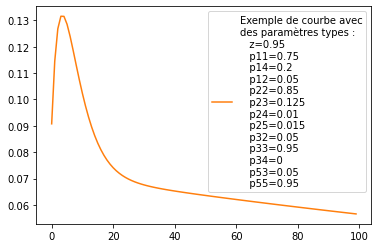

In [27]:
p11, p14, p22, p24, p25, p32, p55 = 0.75, 0.05, 0.85, 0.01, 0.015, 0.05, 0.95
#(0.6,0.8), (0,0.1), (0.85, 0.95), (0, 0.02), (0,0.02), (0.05, 0.15), (0.95, 1)
Y, probs = calcul_courbe(100, 0.95, p11, p14, 1-p11-p14, p22, 1-p22-p24-p25, p24, p25, p32, 1-p32, 0, 1-p55, p55)
plt.plot(Y,"C1")
plt.legend(["Exemple de courbe avec\ndes paramètres types : \n"+probs])
plt.savefig("Images/ExempleComp.svg")
plt.show()

In [ ]:
pathImages='Images/'
d=datetime.now()
nameF = f"{get_title_from_id(filename.removesuffix('.csv'))}_Compartiment_{d.year}-{d.month}-{d.day}_{d.hour}-{d.minute}-{d.second}.png"
plt.savefig(pathImages+nameF)

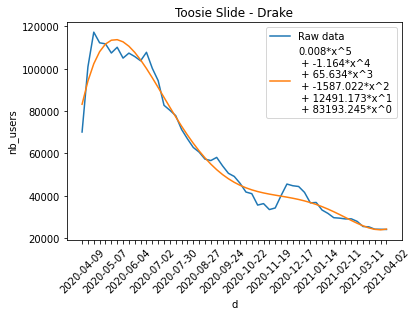

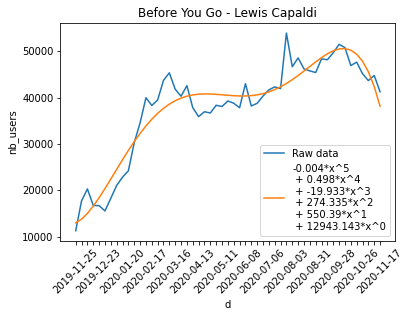

0

In [16]:
#Regression polynomiale
for filename in my_files:
    plt.close()
    #if filename!="1674114547.csv":continue
    df=weekly_average(pd.read_csv(pathDataCSV + filename).sort_values(by="d"))
    plot_graphic(df, "d", "nb_users", filename)
    fit = np.polyfit([i for i in range(len(df["d"]))], df["nb_users"].tolist(), 5)
    f_reg=np.poly1d(fit)
    plt.plot(df["d"], [f_reg(i) for i in range(len(df["d"]))])
    plt.legend(["Raw data", "\n + ".join([f"{round(fit[i],3)}*x^{len(fit)-i-1}" for i in range(len(fit))])])
    plt.show()
0

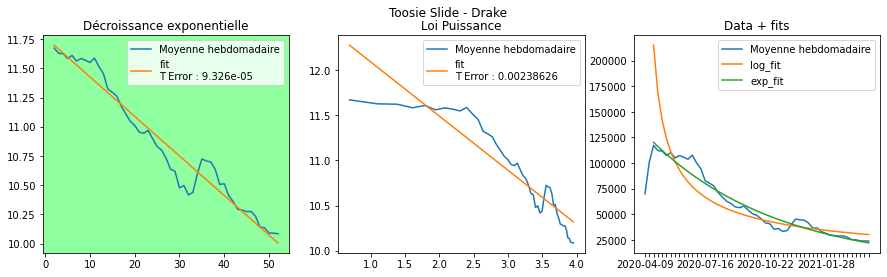

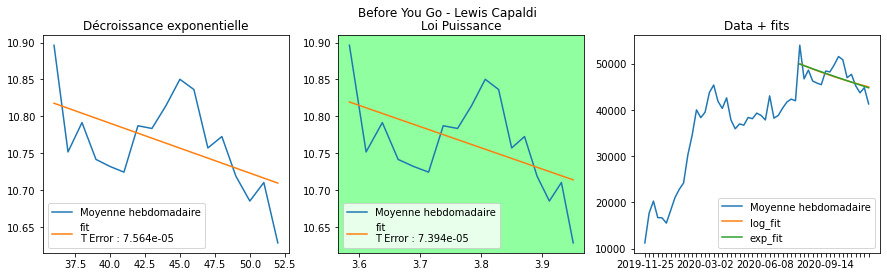

0

In [19]:
#fit avec loi puissance et décroissance exponentielle (ne fit qu'à partir du pic, pour ignorer le temps de montée)
for filename in my_files:
    plt.close()
    df=weekly_average(pd.read_csv(pathDataCSV + filename).sort_values(by="d"))
    titre = metadata[metadata['song_id'] == filename.removesuffix('.csv')]["song_title"].tolist()[0] + ' - ' + (metadata[metadata['song_id'] == filename.removesuffix('.csv')])["artist_name"].tolist()[0]
    y_max=max(df["nb_users"])
    x_min=max(1, df["nb_users"].tolist().index(y_max)) #on utilise des log après donc on ne veut pas x==0
    y_min=min(df["nb_users"][x_min:])-1 #on enlève un pour que y-y_min ne puisse jamais faire 0
    
    #approximation des courbes, log-log pour montrer la présence d'une loi puissance ou log-x pour la décroissance exponentielle
    fit_log = np.polyfit([log(i) for i in range(x_min,len(df["d"]))], [log(y) for y in df["nb_users"].tolist()[x_min:]], 1)
    f_reg_log=np.poly1d(fit_log)
    fit_exp = np.polyfit([i for i in range(x_min,len(df["d"]))], [log(y) for y in df["nb_users"].tolist()[x_min:]], 1)
    f_reg_exp=np.poly1d(fit_exp)
    
    #affichage des différentes courbes 
    fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,4))
    fig.suptitle(titre)

    #ax3 contient la courbe réel et les fits de décroissances une fois remis à l'échelle
    ax3.plot(df["d"], df["nb_users"])
    ax3.set_title("Data + fits")
    ax3.plot(df["d"][x_min:], [exp(f_reg_log(log(i))) for i in range(x_min, len(df["d"]))])
    ax3.plot(df["d"][x_min:], [exp(f_reg_exp(i)) for i in range(x_min, len(df["d"]))])
    ax3.legend(["Moyenne hebdomadaire", "log_fit", "exp_fit"])
    #on n'affiche qu'une partie des dates pour que cela reste visible
    n=ceil(len(df['d'])/4)
    for i, label in enumerate(ax3.xaxis.get_ticklabels()):
        if i % n != 0:
            label.set_visible(False)
    
    #on affiche en log log pour voir si c'est une loi puissance, si on a une décroissance linéaire, s'en est une
    Xlog_xmin_end = [log(i) for i in range(x_min, len(df["d"]))]
    Ylog_df_nb_users = [log(y) for y in df["nb_users"][x_min:]]
    Yfit_log = [fit_log[1]+fit_log[0]*log(i) for i in range(x_min, len(df["d"]))]
    ax2.plot(Xlog_xmin_end, Ylog_df_nb_users)
    ax2.plot(Xlog_xmin_end, Yfit_log)
    ax2.set_title("Loi Puissance")
    mc_log = moindre_carres(Yfit_log, Ylog_df_nb_users)
    ax2.legend(["Moyenne hebdomadaire", f"fit\nT Error : {round(mc_log,8)}"])
    
    #on affiche en x log pour voir si c'est une décroissance exponentielle, si on a une décroissance linéaire, s'en est une
    X_xmin_end = [i for i in range(x_min, len(df["d"]))]
    Yfit_reg = [f_reg_exp(i) for i in range(x_min, len(df["d"]))]
    ax1.plot(X_xmin_end, Ylog_df_nb_users)
    ax1.plot(X_xmin_end, Yfit_reg)
    ax1.set_title("Décroissance exponentielle")
    mc_exp = moindre_carres(Yfit_reg, Ylog_df_nb_users)
    ax1.legend(["Moyenne hebdomadaire", f"fit\nT Error : {round(mc_exp, 8)}"])
    
    if mc_exp<mc_log:
        ax1.patch.set_facecolor('xkcd:mint green')
    else:
        ax2.patch.set_facecolor('xkcd:mint green')
    plt.savefig("Images/AnalyseDonnee_"+titre+".svg")
    plt.show()
0

Saved - Images/ModComp_Toosie Slide-Drake.svg


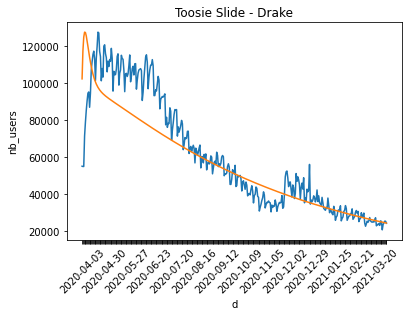

Saved - Images/ModComp_Before You Go-Lewis Capaldi.svg


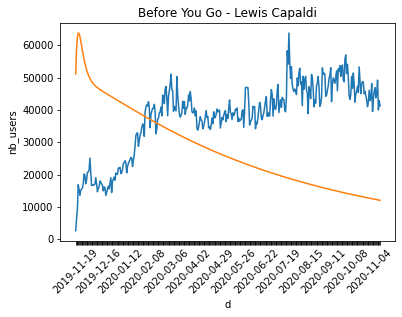

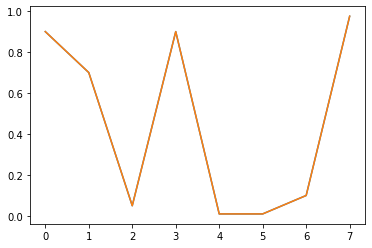

In [ ]:
poptS=[]

for filename in my_files:
    plt.close()
    df=pd.read_csv(pathDataCSV + filename).sort_values(by="d")
    plot_graphic(df, "d", "nb_users", filename)
    x_min=min(len(df["d"])-10, max(1, df["nb_users"].tolist().index(max(df["nb_users"]))))
    nb_user_dec = df["nb_users"].tolist()
    
    #     z          p11        p14      p22           p24        p25       p32           p55
    b_t=[(0.95,1.0), (0.5,0.8), (0,0.1), (0.85, 0.95), (0, 0.02), (0,0.02), (0.05, 0.15), (0.95, 1)]
    b_t=[(0.80,1.0), (0.6,0.8), (0,0.1), (0.85, 0.95), (0, 0.02), (0,0.02), (0.05, 0.15), (0.95, 1)]
    boundaries=[[x for x,y in b_t],[y for x,y in b_t]]
    popt, pcov = curve_fit(calcul_courbe_aux, nb_user_dec, nb_user_dec, method='dogbox', bounds=boundaries)
    plt.plot(df["d"], calcul_courbe_aux(nb_user_dec, *popt))
    poptS.append(popt)
    title=(metadata[metadata['song_id'] == filename.removesuffix('.csv')])["song_title"].tolist()[0] + '-' + (metadata[metadata['song_id'] == filename.removesuffix('.csv')])["artist_name"].tolist()[0]
    plt.savefig("Images/ModComp_"+title+".svg")
    print("Saved - Images/ModComp_"+title+".svg")
    plt.show()
    
for k in range(len(poptS)): //affiche les paramètres des différentes courbes
    plt.plot([i for i in range(len(poptS[k]))], poptS[k])
plt.show()